# Experiments Pertaining to Modeling

#### Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import random
from pathlib import Path
from collections import OrderedDict
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
#import missingno as mso
#import pandas_profiling as pdp

import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

from torchvision import models
import torchvision.transforms as T
#from torchvision.utils import make_grid
#from efficientnet_pytorch import EfficientNet
#import torchsummary
# local files
from plotting import show_batch, plot_learning_curves
from modeling import CheXModel

C:\Users\Rygu\Anaconda3\envs\mldl\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


#### Globals

In [2]:
USE_CUDA = True
ON_AWS = True
NUM_WORKERS = 4 if ON_AWS else 0 
DEVICE = torch.device('cuda' if torch.cuda.is_available() and USE_CUDA else 'cpu')

In [3]:
SEED = 404
def seed_everything(seed=SEED, env=None):
    random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [4]:
PATH_DATA = Path('data/')
chxpath = PATH_DATA/'CheXpert-v1.0-small/'
path_train = chxpath/'train'
path_valid = chxpath/'valid'

In [9]:
TARGET_LABELS = ['No_Finding', 'Enlarged_Cardiomediastinum', 'Cardiomegaly',
       'Lung_Opacity', 'Lung_Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural_Effusion', 'Pleural_Other',
       'Fracture', 'Support_Devices']

## Data

In [5]:
df_train = pd.read_csv(chxpath/'train.csv')
df_valid = pd.read_csv(chxpath/'valid.csv')

In [51]:
def label_smooth(df, method='uones', smooth_bounds=None):
    df_sub = df.copy()
    if smooth_bounds is None:
        eps = 1e-5
        if method == 'uones':
            smooth_bounds = (0.55, 0.85+eps)
        elif method=='uzeros':
            smooth_bounds = (0, 0.30+eps)
        else:
            smooth_bounds = (0, 0.85+eps)
    
    if method in ['uones','uzeros']:
        smooth_distrb = np.random.uniform(*smooth_bounds,df_sub[TARGET_LABELS].shape)
        df_sub.loc[:,TARGET_LABELS] = np.where(df_sub[TARGET_LABELS]==-1, smooth_distrb, df_sub[TARGET_LABELS])
        
    return df_sub

def proc_df(df, method='uones', smooth=True, nafill_val=0, ufill_val=1, **kwargs):
    """
    Preprocess dataframe for model consumption
    
    Args:
        df (pandas.DataFrame): dataframe containing img paths, metadata, and labels.
        method (str), ('uzeros','uones','constant'): method for replacing uncertainty labels (default: 'uones')
        smooth (bool): use Label Smoothing Regression (LSR) only applies when `method`=('uzeros','uones') (default: True) 
        nafill_val (int,float): value used to fill nan values (default: 0)
        ufill_val (int,float): value used to fill -1 (uncertainty) labels
    
    kwargs:
        smooth_bounds (tuple(float,float)): replace -1 labels uniform random values between the given bounds
        (default: `method`='uzeros': (0,0.3001), `method`='uones': (0.55,0.8501) when `Smooth`=True, 
                
    Returns:
        processed_df: pandas.Dataframe
    """
    
    is_val = df['Path'].str.contains('valid').all()
    df_sub = df.rename(lambda x: x.replace(' ','_'), axis=1).drop(columns=['Sex','Age','Frontal/Lateral','AP/PA'])
    
    if is_val:
        return df_sub # val set has no nans, no -1s
    
    df_targets = df_sub[TARGET_LABELS]
    
    if isinstance(nafill_val,tuple):
        nan_smooth_distrb = np.random.uniform(*nafill_val, df_targets.shape)
        df_sub.loc[:,TARGET_LABELS] = np.where(df_targets.isna(), nan_smooth_distrb, df_targets)
    else:
        df_sub = df_sub.fillna(nafill_val)
    
    if smooth:
        df_sub = label_smooth(df_sub, method, kwargs.get('smooth_bounds'))
    elif method == 'constant':
        df_sub = df_sub.replace(-1,ufill_val)
    elif method in ['uzeros','uones'] and ufill_val not in [0.0,1.0]:
        print(f'WARNING: Overwritting `ufill_val` to match method "{method}"')
        ufill_val = 1.0 if method=='uones' else 0.0
        df_sub = df_sub.replace(-1,ufill_val)
    
    df_sub.loc[:,TARGET_LABELS] = df_sub.loc[:,TARGET_LABELS].astype(float)
    
    return df_sub

## Image Augmentations

In [157]:
FRONTAL_TEMPLATE1c = cv2.imread('templates/fnt_ext_template244.jpg', 0)
LATERAL_TEMPLATE1c = cv2.imread('templates/lat_ext_template244.jpg', 0)

def template_match(img, template, tm_method=cv2.TM_CCOEFF_NORMED, init_resize=(256,256)):
    h,w = template.shape
    if img.ndim > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img1c256 = cv2.resize(img, init_resize, interpolation=cv2.INTER_LINEAR)

    res = cv2.matchTemplate(img1c256, template, tm_method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    top_left = max_loc if tm_method not in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED] else min_loc
    bottom_right = (top_left[0] + w, top_left[1]+h)
    (x,y),(x1,y1) = top_left, bottom_right
    
    return cv2.cvtColor(img1c256[y:y1, x:x1], cv2.COLOR_GRAY2BGR)

In [158]:
class TemplateCrop(A.ImageOnlyTransform):
    """Match image to template of either a lateral or frontal view, resizing and cropping in the process.
    Args:
        tm_method (int): Template matching method
    Targets:
        image
    Image types:
        uint8, float32
    """

    def __init__(self, tm_method=cv2.TM_CCOEFF_NORMED, init_resize=(256,256), always_apply=False, p=1.0):
        super(TemplateCrop, self).__init__(always_apply, p)
        self.tm_method = tm_method
        self.init_resize = init_resize

    def apply(self, image, **params):
        template = LATERAL_TEMPLATE1c if params.get('is_lateral') else FRONTAL_TEMPLATE1c
        return template_match(image, template, self.tm_method, self.init_resize)

    def get_transform_init_args_names(self):
        return ("tm_method","init_resize")

In [452]:
def advprop(image,**kwargs):
    return image*2.0-1.0
def get_transforms(varient='train', tfms_lib='albu', imgsize=(244,244)):
    if tfms_lib == 'albu':
        transform = A.Compose([
            A.RandomScale((-0.02,0.02)),
            A.OneOf([
                TemplateCrop(init_resize=(256, 256), p=1.0),
                A.Compose([A.Resize(256,256, p=1.0),A.CenterCrop(*imgsize, p=1.0)])
            ],p=1.0),
            A.CLAHE(p=0.5),
            A.HorizontalFlip(),
            A.Rotate((-7,7)),#,border_mode=cv2.BORDER_CONSTANT),
            A.IAAAffine(shear=(-5,5)),
            A.Cutout(8,8,8),
            
            #A.Lambda(advprop),
            A.Normalize(),
            ToTensorV2(),
        ])
        
        tta_augments = A.Compose([
            A.OneOf([
                TemplateCrop(init_resize=(256, 256), p=1.0),
                A.Compose([A.Resize(256,256, p=1.0), A.CenterCrop(*imgsize,p=1.0)])
            ],p=1.0),
            A.OneOf([
                A.HorizontalFlip(),
                A.Rotate((-7,7)),#border_mode=cv2.BORDER_CONSTANT),
                A.IAAAffine(shear=(-5,5)),
                A.NoOp()
            ],p=1.0),
            A.Normalize(),
            ToTensorV2()
        ])
        
    elif tfms_lib == 'torch':
        transform = T.Compose([
            #T.RandomCrop(512,8,padding_mode='reflect') ,
            T.CenterCrop(imgsize),
            T.RandomHorizontalFlip(),
            T.RandomRotation(7),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
            #T.RandomErasing(inplace=True)
        ])
        tta_augments = T.Compose([T.CenterCrop(32),T.ToTensor()])
        
    return transform if varient == 'train' else tta_augments

## Dataset / DataLoader

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
# (blank for unmentioned, 0 for negative, -1 for uncertain, and 1 for positive)
class CheXDataset(Dataset):
    def __init__(self, df, use_albu=True, tfms=None, smooth_bounds=None, seed=None, dpath=PATH_DATA):
        
        self.df = df
        self.paths = self.df['Path'].values
        self.labels = self.df.iloc[:,1:].values.astype(float)
        #self.dpath = dpath
        self.tfms = tfms
        
        self.use_albu = use_albu
        self.smooth_bounds = smooth_bounds
        self._seedcntr=seed
        if self.tfms is not None:
            self.tfm_list = self.tfms.transforms.transforms if self.use_albu else self.tfms.transforms 
    
    def __len__(self,):
        return len(self.df)
    
    def __getitem__(self,idx):
        if self._seedcntr is not None:
            random.seed(self._seedcntr)
            self._seedcntr+=1
        labels = self.labels[idx]
        if self.smooth_bounds is not None:
            labels = np.where(labels==-1.,np.random.uniform(*self.smooth_bounds, size=len(labels)),labels)
        
        imgpath = str(PATH_DATA/self.paths[idx])
        
        is_lateral = 'lateral' in imgpath
        if self.use_albu:
            img = cv2.imread(imgpath)
            #img = template_match(img, template)
            #img = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
            #img = np.expand_dims(cv2.imread(imgpath,cv2.IMREAD_GRAYSCALE),2)
            aug = self.tfms(image=img, is_lateral=is_lateral)
            img = aug['image']
        else:
            img = Image.open(imgpath)
            img = self.tfms(img)
        
        return img,labels

In [ ]:
def get_dloaders(batch_size=32, sampsz=None, tfmlib='albu', seed=None, proc_kwargs=None):
    if seed is not None:
        seed_everything(seed)

    if proc_kwargs is None:
        proc_kwargs = dict(method='uones',smooth=True, nafill_val=0)
    
    df_trn = proc_df(df_train, **proc_kwargs)
    df_val = proc_df(df_valid)
    if sampsz is not None:
        df_trn = df_trn.sample(sampsz) #17->65k, 13->8k
    
    ualbu = (tfmlib=='albu')
    train_tfm = get_transforms('train', tfmlib, (244,244))
    valid_tfm = get_transforms('test', tfmlib, (244,244))

    train_dataset = CheXDataset(df=df_trn, use_albu=ualbu, tfms=train_tfm, seed=seed)#smooth_bounds=(0.55,0.8501)
    valid_dataset = CheXDataset(df=df_val, use_albu=ualbu, tfms=valid_tfm)

    train_loader = DataLoader(train_dataset, batch_size, pin_memory=USE_CUDA, num_workers=NUM_WORKERS)
    valid_loader = DataLoader(valid_dataset, batch_size, pin_memory=USE_CUDA, num_workers=NUM_WORKERS, shuffle=False)
    
    return train_loader, valid_loader

## Model

### Model Helpers

In [ ]:
@torch.no_grad()
def compute_auc(out,target):
    targ = target.round().detach().to('cpu')
    out = torch.sigmoid(out).detach().to('cpu')
    score = roc_auc_score(targ, out, average='micro',multi_class='ovo')

    return score

@torch.no_grad()
def compute_auc_dbg(out,target,ninv=0):
    try:
        targ = target.round().detach().to('cpu')
        out = torch.sigmoid(out).detach().to('cpu')#out.detach().to('cpu')#F.softmax(out,0).detach().to('cpu')
        #score = roc_auc_score(targ, out, multi_class='ovo')
        score = roc_auc_score(targ, out, average='micro',multi_class='ovo')
    except ValueError as e:
        score = 0.5
        ninv+=1
        #score = 0.5
    return score,ninv

In [382]:
def save_history(history, save_name, description, save_path='save/histories/'):
    full_path = Path(save_path)
    full_path.mkdir(parents=True, exist_ok=True)
    desc = f'{save_name} - {description} \n'
    with full_path.joinpath('description.txt').open('a+') as f:
        f.write(desc)
    dump_path = full_path.joinpath(save_name).with_suffix('.pkl')    
    pickle.dump(history,dump_path.open('wb'))
    print('File saved to:',str(dump_path))

In [383]:
def save_trained(model, save_name, description=None, module='network', save_path='save/models/'):
    full_path = Path(save_path)
    full_path.mkdir(parents=True, exist_ok=True)
    modelmod = getattr(model,module,model)
    states = OrderedDict(
        {n: c.state_dict() for n,c in modelmod.named_children() if any(p.requires_grad for p in c.parameters())}
    )
    if description is not None:
        desc = f"{save_name} - ({', '.join(states.keys())}) : {description} \n"
        with full_path.joinpath('description.txt').open('a+') as f:
            f.write(desc)
    
    out_path = full_path.joinpath(save_name).with_suffix('.pt')
    torch.save(states,out_path)
    
    print('state dict saved to:',out_path.as_posix())
    
def load_trained(model, save_name, module='network', save_path='save/models/'):
    """
    Example:
    model = CheXModel('densenet121')
    model = load_trained(model,'densenet121.pt')
    """
    load_path = Path(save_path).joinpath(save_name).with_suffix('.pt')
    saved_odict = torch.load(load_path)
    modelmod = getattr(model,module,model)
    
    for k,v in saved_odict.items():
        getattr(modelmod,k).load_state_dict(v)
        
    model.to(DEVICE)
    return model

## Training

In [384]:
class TrainerBase:
    def __init__(self):
        self.history = {}
    
    def freeze(self, param_names=None, invert=True, unfreeze=False):
        init_trainables = np.array([p.requires_grad for p in self.model.parameters()])
        trainable_params = np.array([n for n,p in self.model.named_parameters()])[init_trainables]
        n_params = len(init_trainables)

        child_names,children = zip(*[*self.model.named_children()])
        n_child = len(children)
        
        if param_names is None:
            child_train = [[x.requires_grad for x in child.parameters()] for child in self.model.children()]
            lay_df = pd.DataFrame({'Name':child_names,'Trainable': [f'{sum(c)}/{len(c)}' for c in child_train]})#.set_index('Name')
            print(lay_df)

            print('Frozen Parameters: ({} / {})'.format((~init_trainables).sum(),n_params))
            print('Trainable Parameters: ({} / {})'.format(init_trainables.sum(),n_params))
            return
        
        params_status = {'trainable':[],'frozen':[]}
        for name,param in self.model.named_parameters():
            if all(map(lambda x: x not in name, param_names)):
                if invert:
                    if name in trainable_params:
                        params_status['frozen'].append(name)
                    param.requires_grad = unfreeze
                else:
                    param.requires_grad = !unfreeze
            else:
                params_status['trainable'].append(name)
        print(f'Trainable: {len(params_status["trainable"])}, Frozen: {len(params_status["frozen"])}')
        return params_status

        
    def update_history(self, **kwargs):
        for k,v in kwargs.items():
            self.history.setdefault(k,[]).append(v)
            
    def to_device(self, data, device):
        """Move tensor(s) to chosen device"""
        if isinstance(data, (list,tuple)):
            return [self.to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)
    
    def save_improved(self, score, best_score, save_name=None, save_path='saves/models'):
        if score > best_score:
            print(f'Score improved: {score:.5f} > {best_score:.5f}')
            best_score = score
            if save_name is not None:
                save_trained(self.model, save_name, save_path=save_path)
                #torch.save(self.model.state_dict(), Path(save_path)/save_name)
        return best_score
    
    def train_batch_end(self, i, log_freq, **kwargs):
        if log_freq is not None and i % log_freq==0:
            self.update_history(**kwargs)
    
    def train_epoch_end(self, **kwargs):
        self.update_history(**kwargs)#{'train_loss':loss,'train_auc':auc})
    
    def validation_epoch_end(self, **kwargs):
        self.update_history(**kwargs)#{'valid_loss':loss, 'valid_auc':auc}
    
    def epoch_end(self, epoch, exclude_keys=None):
        if exclude_keys is None:
            exclude_keys = ()
        hist_str = f'Epoch [{epoch}] '+', '.join([f'{k}: {v[-1]:.4f}' for k,v in self.history.items() if k not in exclude_keys])
        print(hist_str)

In [457]:
class Trainer(TrainerBase):
    def __init__(self, model, optimizer, criterion, scheduler=None, device=DEVICE):
        super(Trainer,self).__init__()
        self.device = device
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.criterion = criterion.to(self.device)
        self.scheduler = scheduler
    
    def train(self, train_loader, valid_loader, n_epochs=1, log_freq=None, save_name=None):
        best_val_auc = 0.0
        
        pbar = tqdm(range(n_epochs))
        for epoch in pbar:
            train_loss, train_auc = self.train_one(train_loader, pbar, log_freq)
            self.train_epoch_end(train_loss=train_loss, train_auc=train_auc)
            
            valid_loss, valid_auc = self.evaluate(valid_loader, pbar)
            self.validation_epoch_end(valid_loss=valid_loss, valid_auc=valid_auc)
            
            best_val_auc = self.save_improved(valid_auc, best_val_auc, save_name=save_name)
            
            if self.scheduler is not None:
                self.scheduler.step()
                
            self.epoch_end(epoch, exclude_keys=['intraepoch_tloss','intraepoch_tauc'])
        
        return self.history
    
    
    def train_one(self, data_loader, pbar, log_freq=None):
        self.model.train()
        tloss,tauc=0,0
        nbat = len(data_loader)
        for i, batch in enumerate(tqdm(data_loader, leave=False)):
            data,target = self.to_device(batch, self.device)

            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)

            loss.backward()
            self.optimizer.step()
            
#             if self.scheduler is not None:
#                 self.scheduler.step()
                
            tloss+=loss.item()
            tauc+=compute_auc(output,target)
            
            itloss,itauc = tloss/(i+1),tauc/(i+1)
            pbar.set_postfix({'TLoss': f'{itloss:.4f}','TAUC': f'{itauc:.4f}'})
            self.train_batch_end(i,log_freq, intraepoch_tloss=itloss, intraepoch_tauc=itauc)
        
        return tloss/nbat, tauc/nbat
    
    @torch.no_grad()
    def evaluate(self, data_loader, pbar):
        self.model.eval()
    
        vlosses,vaucs=[],[]
        for i, batch in enumerate(tqdm(data_loader, leave=False)):
            data,target = self.to_device(batch, self.device)

            output = self.model(data)
            loss = self.criterion(output, target)
            
            vlosses.append(loss.detach().item())
            vauc = compute_auc(output,target)
            vaucs.append(vauc)
            
            pbar.set_postfix({'VLoss': f'{np.mean(vlosses):.4f}', 'VAUC': f'{np.mean(vaucs):.4f}'})
        
        return np.mean(vlosses), np.mean(vaucs)

In [460]:
def make_trainer(arch='densenet121', lr=1e-3, train_loader=None, scheduler=None):
    if train_loader is not None:
        show_batch(train_loader,denorm=True)
    
    criterion = nn.BCEWithLogitsLoss()
    model = CheXModel(arch)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if scheduler=='steplr':
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1, verbose=True)
    trainer = Trainer(model, optimizer, criterion, scheduler)
    pstat = trainer.freeze(['_fc','fc','network.classifier','classifier'],invert=True)
    return trainer

## Experiments

### Models

#### DenseNet161

==================== Augmentations ====================
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
-------------------------------------------------------


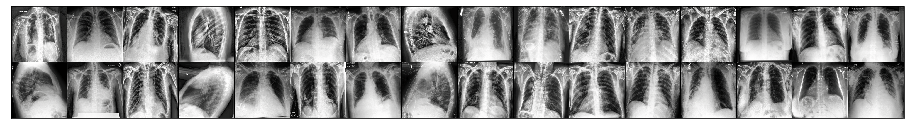

Trainable: 2, Frozen: 482


Score improved: 0.81320 > 0.00000
Epoch [0] train_loss: 0.3964, train_auc: 0.7952, valid_loss: 0.3979, valid_auc: 0.8132


Score improved: 0.81612 > 0.81320
Epoch [1] train_loss: 0.3797, train_auc: 0.8165, valid_loss: 0.3971, valid_auc: 0.8161


Epoch [2] train_loss: 0.3741, train_auc: 0.8237, valid_loss: 0.3980, valid_auc: 0.8159


Epoch [3] train_loss: 0.3707, train_auc: 0.8281, valid_loss: 0.3993, valid_auc: 0.8154


Epoch [4] train_loss: 0.3682, train_auc: 0.8311, valid_loss: 0.4006, valid_auc: 0.8146



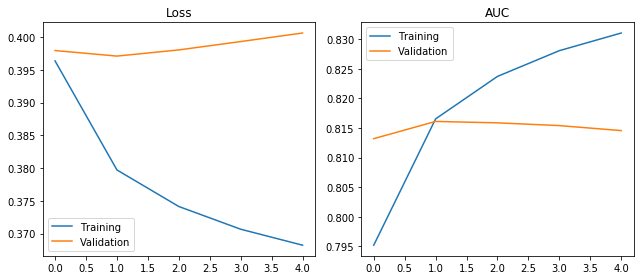

CPU times: user 21min 7s, sys: 6min 45s, total: 27min 52s
Wall time: 27min 39s


In [61]:
%%time
train_loader, valid_loader = get_dloaders(32, 2**14, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model161 = CheXModel('densenet161')
optimizer = optim.Adam(model161.parameters(), lr=1e-3)
trainer = Trainer(model161,optimizer,criterion)
parstatus = trainer.freeze(['_fc','fc','network.classifier','classifier'],invert=True)
hist = trainer.train(train_loader, valid_loader, 5)
save_history(hist,'densenet161',f"samples 16k, batch 32, lr 1e-3, highest val auc, {max(hist['valid_auc']):0.5f}")
plot_learning_curves(hist)

#### DenseNet201

==================== Augmentations ====================
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
-------------------------------------------------------


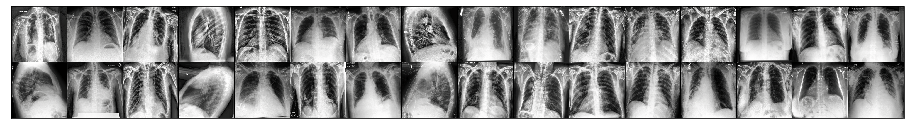

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/densenet201-c1103571.pth



Trainable: 2, Frozen: 602


Score improved: 0.81967 > 0.00000
Epoch [0] train_loss: 0.3969, train_auc: 0.7950, valid_loss: 0.3935, valid_auc: 0.8197


Epoch [1] train_loss: 0.3810, train_auc: 0.8151, valid_loss: 0.3942, valid_auc: 0.8185


Epoch [2] train_loss: 0.3755, train_auc: 0.8221, valid_loss: 0.3955, valid_auc: 0.8166


Epoch [3] train_loss: 0.3721, train_auc: 0.8264, valid_loss: 0.3968, valid_auc: 0.8151


Epoch [4] train_loss: 0.3698, train_auc: 0.8293, valid_loss: 0.3979, valid_auc: 0.8141



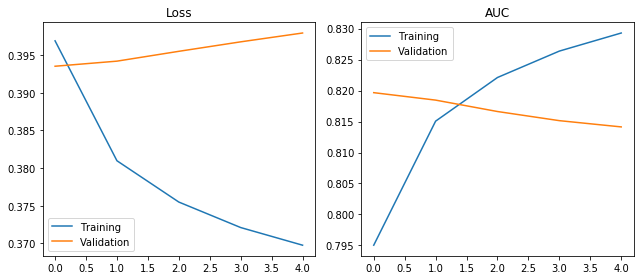

CPU times: user 15min 14s, sys: 3min 59s, total: 19min 14s
Wall time: 19min


In [67]:
%%time
train_loader, valid_loader = get_dloaders(32, 2**14, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model201 = CheXModel('densenet201')
optimizer = optim.Adam(model201.parameters(), lr=1e-3)
trainer = Trainer(model201,optimizer,criterion)
parstatus = trainer.freeze(['_fc','fc','network.classifier','classifier'],invert=True)
hist = trainer.train(train_loader, valid_loader, 5)

save_desc = f"samples 16k, batch 32, lr 1e-3, max val AUC, {max(hist['valid_auc']):0.5f}"
save_history(hist,'densenet201', save_desc)
save_trained(model201,'densenet201',save_desc)

#### resnext50_32x4d

==================== Augmentations ====================
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
-------------------------------------------------------


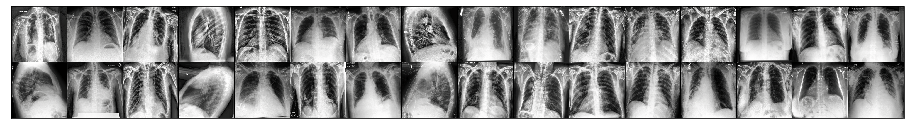

Trainable: 2, Frozen: 159


Score improved: 0.76371 > 0.00000
Epoch [0] train_loss: 0.4044, train_auc: 0.7863, valid_loss: 0.4376, valid_auc: 0.7637


Score improved: 0.77042 > 0.76371
Epoch [1] train_loss: 0.3915, train_auc: 0.8029, valid_loss: 0.4344, valid_auc: 0.7704


Score improved: 0.77328 > 0.77042
Epoch [2] train_loss: 0.3875, train_auc: 0.8084, valid_loss: 0.4334, valid_auc: 0.7733


Score improved: 0.77524 > 0.77328
Epoch [3] train_loss: 0.3849, train_auc: 0.8119, valid_loss: 0.4331, valid_auc: 0.7752


Score improved: 0.77647 > 0.77524
Epoch [4] train_loss: 0.3828, train_auc: 0.8146, valid_loss: 0.4329, valid_auc: 0.7765



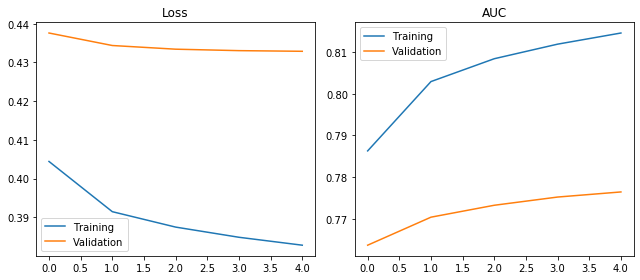

CPU times: user 13min 38s, sys: 3min 44s, total: 17min 22s
Wall time: 17min 5s


In [79]:
%%time
train_loader, valid_loader = get_dloaders(32, 2**14, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model_re = CheXModel('resnext50_32x4d')
model_re.network.fc = nn.Linear(2048,14)
optimizer = optim.Adam(model_re.parameters(), lr=1e-3)
trainer = Trainer(model_re,optimizer,criterion)
parstatus = trainer.freeze(['_fc','fc','network.classifier','classifier'],invert=True)
hist = trainer.train(train_loader, valid_loader, 5)
#save_history(hist,'densenet201',"samples 16k, batch 32, lr 1e-3, highest val auc, 0.8197")
plot_learning_curves(hist)

#### Wide Resnet101_2

==================== Augmentations ====================
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
-------------------------------------------------------


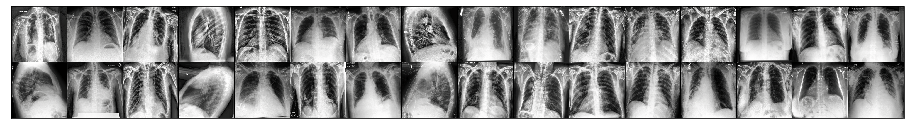

Trainable: 2, Frozen: 312


Score improved: 0.77116 > 0.00000
Epoch [0] train_loss: 0.4031, train_auc: 0.7869, valid_loss: 0.4271, valid_auc: 0.7712


Score improved: 0.77334 > 0.77116
Epoch [1] train_loss: 0.3902, train_auc: 0.8037, valid_loss: 0.4259, valid_auc: 0.7733


Score improved: 0.77507 > 0.77334
Epoch [2] train_loss: 0.3861, train_auc: 0.8095, valid_loss: 0.4256, valid_auc: 0.7751


Score improved: 0.77602 > 0.77507
Epoch [3] train_loss: 0.3834, train_auc: 0.8131, valid_loss: 0.4257, valid_auc: 0.7760


Score improved: 0.77685 > 0.77602
Epoch [4] train_loss: 0.3813, train_auc: 0.8158, valid_loss: 0.4258, valid_auc: 0.7769



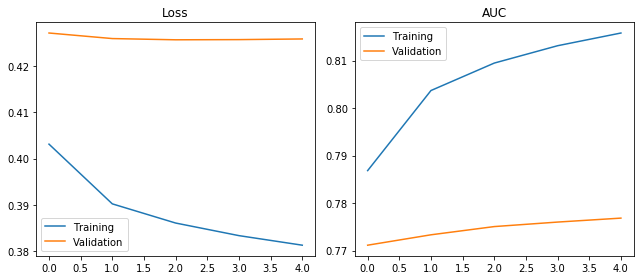

CPU times: user 26min 50s, sys: 7min 44s, total: 34min 34s
Wall time: 34min 23s


In [58]:
%%time
train_loader, valid_loader = get_dloaders(32, 2**14, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model_wr = CheXModel('wide_resnet101_2')
optimizer = optim.Adam(model_wr.parameters(), lr=1e-3)
trainer = Trainer(model_wr,optimizer,criterion)
parstatus = trainer.freeze(['_fc','fc','network.classifier','classifier'],invert=True)
hist = trainer.train(train_loader, valid_loader, 5)
plot_learning_curves(hist)

#### Efficientnet-B5

==================== Augmentations ====================
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Rotate(always_apply=False, p=0.5, limit=(-7, 7), interpolation=1, border_mode=4, value=None, mask_value=None)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
-------------------------------------------------------


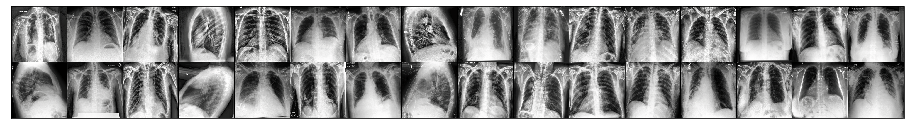

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5
Trainable: 2, Frozen: 504


Score improved: 0.73692 > 0.00000
Epoch [0] train_loss: 0.4467, train_auc: 0.7463, valid_loss: 0.4712, valid_auc: 0.7369


Score improved: 0.76679 > 0.73692
Epoch [1] train_loss: 0.4103, train_auc: 0.7801, valid_loss: 0.4314, valid_auc: 0.7668


Score improved: 0.77963 > 0.76679
Epoch [2] train_loss: 0.4006, train_auc: 0.7908, valid_loss: 0.4193, valid_auc: 0.7796


Score improved: 0.78257 > 0.77963
Epoch [3] train_loss: 0.3957, train_auc: 0.7963, valid_loss: 0.4152, valid_auc: 0.7826


Score improved: 0.78287 > 0.78257
Epoch [4] train_loss: 0.3923, train_auc: 0.8009, valid_loss: 0.4150, valid_auc: 0.7829



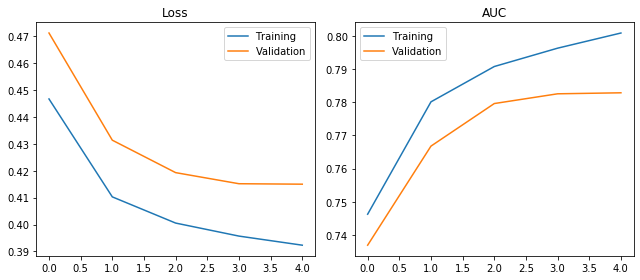

CPU times: user 22min 23s, sys: 6min 38s, total: 29min 2s
Wall time: 28min 50s


In [55]:
%%time
train_loader, valid_loader = get_dloaders(32, 2**14, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
#model = CheXModel('densenet121')
model_ef = EfficientNet.from_pretrained("efficientnet-b5", advprop=False, num_classes=14)
model_ef._fc = nn.Linear(model_ef._fc.in_features,14)
optimizer = optim.Adam(model_ef.parameters(), lr=1e-3)

trainer = Trainer(model_ef,optimizer,criterion)
parstatus = trainer.freeze(['_fc'],invert=True)
hist = trainer.train(train_loader, valid_loader, 5)
plot_learning_curves(hist)